Banco de dados com valores de alugueis de imóveis de 5 cidades brasileiras: São Paulo, Rio de Janeiro, Belo Horizonte, Porto Alegre e Campinas.

Fazer a predição dos valores através de modelos que utilizam regressão.

Fonte: https://www.kaggle.com/datasets/fabiobarreto/imoveis-aluguel

# **PRÉ-PROCESSAMENTO**

In [ ]:
!pip install scikeras

In [ ]:
import numpy as np
%matplotlib inline
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.pipeline import Pipeline
from keras.layers import Dense, Dropout
from sklearn.impute import SimpleImputer
from tensorflow.keras import backend as k 
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

**Retiramos algumas Features que não irão interferir no resultado final da rede neural**

In [ ]:
df = pd.read_csv("casas_aluguel.csv")

In [ ]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


**Não há dados nulos no dataframe**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [ ]:
df.isna().sum()

city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

Vemos que na coluna "floor" não há dados nulos, mas foi preenchido por "-" nos espaços vazios. Vamos transformar em "NaN" para um melhor tratamento na criação dos modelos.

In [ ]:
df["floor"].value_counts()

-      2461
1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

In [ ]:
df["floor"].replace("-", np.nan, inplace=True)

**Conferindo:**

In [ ]:
df["floor"].value_counts()

1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

**Agora vamos tratar o NaN dentro da coluna "floor":**

In [ ]:
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df[["floor"]])

m = ss.transform(df[["floor"]])
df[["floor"]] = m

**Separando Features de Target:**

In [ ]:
X = df.drop(columns=["total (R$)"])
y = df["total (R$)"]

In [ ]:
df.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7.0,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20.0,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6.0,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2.0,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1.0,not acept,not furnished,0,800,25,11,836


**Transformando as Features categóricas em numéricas - OneHotEnconder - Features de dados binários:**

In [ ]:
#"animal", "furniture"
ohe =  OneHotEncoder(handle_unknown='ignore')
ohe.fit(df[["animal"]])


df["animal"] = ohe.transform(df[["animal"]]).toarray()

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [ ]:
# "city", "floor"
oe =  OrdinalEncoder()
oe.fit(df[["city"]])


df["city"] = oe.transform(df[["city"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
X = df.drop(columns=["total (R$)"])
y = df["total (R$)"]

In [ ]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

In [ ]:
ssc = StandardScaler()

ssc.fit(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
h= ssc.transform(df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']])
df[['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor','animal', 'furniture', 'hoa (R$)', 'rent amount (R$)','property tax (R$)', 'fire insurance (R$)']] = h

In [ ]:
df.columns

Index(['city', 'area', 'rooms', 'bathroom', 'parking spaces', 'floor',
       'animal', 'furniture', 'hoa (R$)', 'rent amount (R$)',
       'property tax (R$)', 'fire insurance (R$)', 'total (R$)'],
      dtype='object')

# **DATASET BASE**

In [ ]:
df

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0.752567,-0.147522,-0.432099,-0.878960,-0.383245,0.175502,0.534522,1.761488,0.057145,-0.174935,-0.050103,-0.236589,5618
1,0.752567,0.318035,1.275535,1.253036,-1.012395,2.992689,0.534522,-0.567702,0.001666,0.312099,0.445121,0.203056,7973
2,-0.649497,-0.128899,-1.285916,-0.878960,-0.383245,-0.041205,0.534522,-0.567702,-0.011161,-0.321632,-0.117999,-0.257525,3841
3,-0.649497,-0.182904,-0.432099,-0.878960,-1.012395,-0.908032,0.534522,-0.567702,-0.057981,-0.816881,-0.110920,-0.759976,1421
4,0.752567,-0.231322,-1.285916,-0.878960,-1.012395,-1.124739,-1.870829,-0.567702,-0.075298,-0.908420,-0.109955,-0.885589,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,-0.649497,-0.160557,-0.432099,-0.878960,-0.383245,-0.257912,-1.870829,1.761488,-0.049515,-0.709499,-0.110276,-0.655299,1926
10688,0.752567,0.252857,1.275535,1.253036,1.504205,2.342569,0.534522,-0.567702,0.123527,3.257774,0.195095,2.882798,19260
10689,0.051535,-0.147522,0.421718,0.542371,-1.012395,0.392208,-1.870829,1.761488,-0.012444,0.617228,-0.011167,0.517088,7390
10690,0.051535,-0.054410,-0.432099,-0.168294,0.245905,0.392208,0.534522,1.761488,0.026359,2.377592,-0.028222,2.129120,14020


In [ ]:
X = df.drop(columns=["total (R$)"])
y = df["total (R$)"]

#====================================================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#====================================================================================================
def criarRede(optimizer='rmsprop', init='glorot_uniform'):
    #k.clear_session()
    rn = Sequential([
                #1ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform", input_dim=X_train.shape[1]), # input_dim = nº de colunas
               tf.keras.layers.Dropout(0.2),
                #2ª camada oculta
               tf.keras.layers.Dense(units=7, activation = "relu", kernel_initializer = "random_uniform"),
               tf.keras.layers.Dropout(0.2),
               #Camada de saída
               tf.keras.layers.Dense(units= 1, activation = 'linear')])
    

    rn.compile(optimizer = optimizer, loss = "mean_absolute_error", metrics = ['mean_absolute_error'])


    return rn
#====================================================================================================
kr = KerasRegressor(model=criarRede)

pipe = Pipeline([('kr', kr)])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Opitmização de Hiperparêmetros
params = {"kr__optimizer": ["adam"],
          "kr__batch_size": [10],
          "kr__epochs":[1000]} 
#====================================================================================================
#Motando a grade geral de parâmetros.
grid_kr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring="neg_mean_absolute_error",
                       cv=splitter,
                       verbose=10)

grid_kr.fit(X_train, y_train)

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 504/1000
770/770 [==============================] - 2s 3ms/step - loss: 1302.0287 - mean_absolute_error: 1302.0287
Epoch 505/1000
770/770 [==============================] - 2s 2ms/step - loss: 1340.6199 - mean_absolute_error: 1340.6200
Epoch 506/1000
770/770 [==============================] - 2s 2ms/step - loss: 1331.0310 - mean_absolute_error: 1331.0310
Epoch 507/1000
770/770 [==============================] - 2s 2ms/step - loss: 1375.2430 - mean_absolute_error: 1375.2430
Epoch 508/1000
770/770 [==============================] - 2s 2ms/step - loss: 1303.5022 - mean_absolute_error: 1303.5022
Epoch 509/1000
770/770 [==============================] - 2s 2ms/step - loss: 1289.4613 - mean_absolute_error: 1289.4613
Epoch 510/1000
770/770 [==============================] - 2s 3ms/step - loss: 1320.7622 - mean_absolute_error: 1320.7622
Epoch 511/1000
770/770 [==============================] - 2s 2ms/step - loss: 1376.2709 - mean

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('kr',
                                        KerasRegressor(model=<function criarRede at 0x7efd3518bcb0>))]),
             param_grid={'kr__batch_size': [10], 'kr__epochs': [1000],
                         'kr__optimizer': ['adam']},
             scoring='neg_mean_absolute_error', verbose=10)

In [ ]:
grid_kr.best_params_

{'kr__batch_size': 10, 'kr__epochs': 1000, 'kr__optimizer': 'adam'}

In [ ]:
grid_kr.best_score_

-1073.2014464052752

In [ ]:
y_pred = grid_kr.predict(X_test)

214/214 [==============================] - 0s 1ms/step


In [ ]:
y_pred

array([3419.5796, 2466.531 , 2727.5168, ..., 1553.6906, 3492.6978,
       1314.6624], dtype=float32)

In [ ]:
tabela = pd.DataFrame()

In [ ]:
tabela["Valor real"] = y_test

In [ ]:
tabela["Valor preditivo"] = y_pred

In [ ]:
tabela = tabela.sort_index()
tabela = tabela.reset_index()
tabela 

,index,Valor real,Valor preditivo
0,0,5618,5091.667480
1,3,1421,1372.781494
2,8,16440,14698.057617
3,10,2747,2555.168457
4,14,5343,4862.686523
...,...,...,...
2134,10665,1897,1858.879883
2135,10681,16040,14311.736328
2136,10682,4419,4052.685059
2137,10685,8726,7835.595703


In [ ]:
lista = []
for c in range(tabela.shape[0]):
  if tabela.loc[[c]].values[0][2] < tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][2] / tabela.loc[[c]].values[0][1])*100
      lista.append(valor)
  elif tabela.loc[[c]].values[0][2] > tabela.loc[[c]].values[0][1]:
      valor = (tabela.loc[[c]].values[0][1] / tabela.loc[[c]].values[0][2])*100
      lista.append(valor)
media = np.mean(lista)
print(f"Teve uma média de acerto de {media:.2f}%")

Teve uma média de acerto de 91.27%


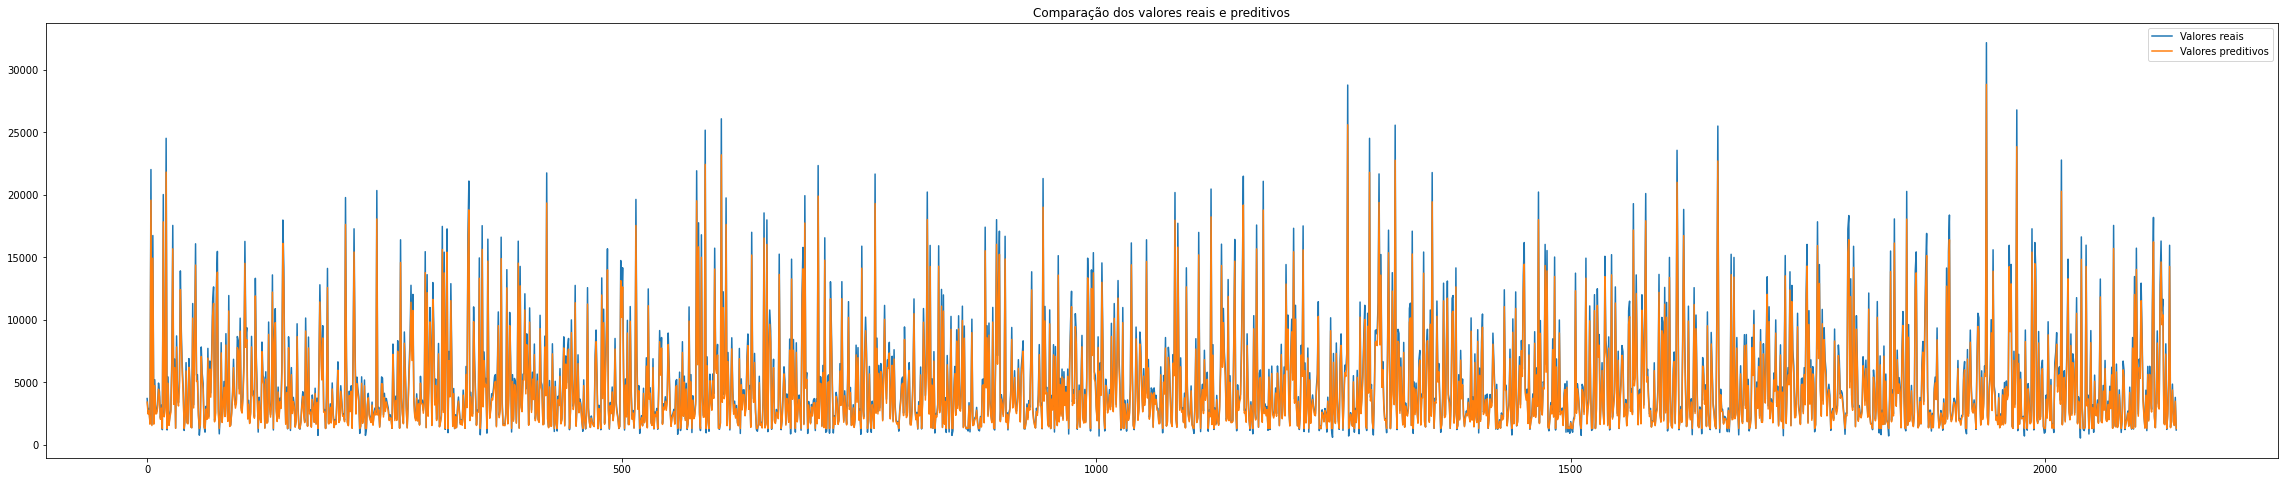

In [ ]:
plt.figure(figsize=(40,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Valores reais")
plt.plot(x_ax, y_pred, label="Valores preditivos")
plt.title("Comparação dos valores reais e preditivos")
plt.legend()
plt.show();

In [ ]:
import pickle

In [ ]:
with open("grid_kr.pkl", "wb") as f:
    pickle.dump(grid_kr, f)

INFO:tensorflow:Assets written to: ram:///tmp/tmpu1yx5wnl/assets


INFO:tensorflow:Assets written to: ram:///tmp/tmpu1yx5wnl/assets


In [ ]:
with open("grid_kr.pkl", "rb") as f:
    
    grid_kr = pickle.load(f)